In [82]:
import os

import numpy

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [83]:
# Библиотека матричного вычисления
import numpy as np
# Библиотека для работы с данными
import pandas as pd
# Библиотека для работы с регулярными выражениями
import re
# Библиотека для работы с фреймворком TensorFlow
import tensorflow as tf

import keras_nlp as nlp

# Библиотека AutoML autokeras
import autokeras as ak
# Библиотеки для построения графиков и их стилизации
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Утилита для расщепления выборки
from sklearn.model_selection import train_test_split

# Необходимые метрики для построения Матрицы ошибок и отчета о классификации
from sklearn.metrics import classification_report, confusion_matrix

In [84]:
# Список доступных устройств
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Доступные устройства GPU:", physical_devices)

# Устанавливаем GPU как предпочтительное устройство (если их несколько)
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)  # Разрешение динамического выделения памяти

# Проверим, используется ли GPU
print("Используется ли GPU:", tf.test.is_gpu_available())

Доступные устройства GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Используется ли GPU: True


In [85]:
features  = [
    'body',
    'subject',
    'type',
]

In [117]:
train = "./dataset/train.csv"
df = pd.read_csv(train)
df.head()

,subject,body,answer,type,queue,priority,language,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8
0,Unvorhergesehener Absturz der Datenanalyse-Pla...,Die Datenanalyse-Plattform brach unerwartet ab...,Ich werde Ihnen bei der Lösung des Problems he...,Incident,General Inquiry,low,de,Crash,Technical,Bug,Hardware,Resolution,Outage,Documentation,NaN
1,Customer Support Inquiry,Seeking information on digital strategies that...,We offer a variety of digital strategies and s...,Request,Customer Service,medium,en,Feedback,Sales,IT,Tech Support,NaN,NaN,NaN,NaN
2,Data Analytics for Investment,I am contacting you to request information on ...,I am here to assist you with data analytics to...,Request,Customer Service,medium,en,Technical,Product,Guidance,Documentation,Performance,Feature,NaN,NaN
3,Krankenhaus-Dienstleistung-Problem,Ein Medien-Daten-Sperrverhalten trat aufgrund ...,Zurück zur E-Mail-Beschwerde über den Sperrver...,Incident,Customer Service,high,de,Security,Breach,Login,Maintenance,Incident,Resolution,Feedback,NaN
4,Security,"Dear Customer Support, I am reaching out to in...","Dear [name], we take the security of medical d...",Request,Customer Service,medium,en,Security,Customer,Compliance,Breach,Documentation,Guidance,NaN,NaN


In [118]:
# Удаляем все столбцы, кроме указанных
df = df.drop(columns=df.columns.difference(features)).dropna()

In [88]:
df.isnull().sum()

subject    0
body       0
type       0
dtype: int64

In [119]:
df['type'].unique()

array(['Incident', 'Request', 'Problem', 'Change'], dtype=object)

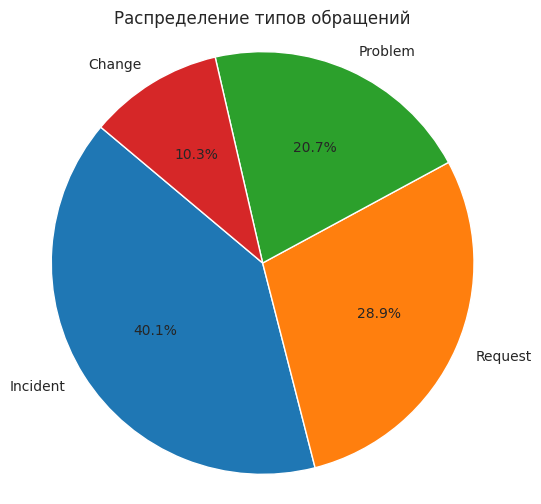

In [120]:
import matplotlib.pyplot as plt

# Подсчёт количества каждой метки
type_counts = df['type'].value_counts()

# Построение круговой диаграммы
plt.figure(figsize=(6, 6))
plt.pie(type_counts, labels=type_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Распределение типов обращений')
plt.axis('equal')  # Круглая форма
plt.show()


In [90]:
def clean_headline(text):
    # Удаляем все символы, кроме букв
    return re.sub(r'[^a-zA-Zа-яА-ЯёЁ\s]+', '', text.lower())


for feature in features:
    df[feature] = df[feature].apply(clean_headline)


In [91]:
df

,subject,body,type
0,unvorhergesehener absturz der datenanalyseplat...,die datenanalyseplattform brach unerwartet ab ...,incident
1,customer support inquiry,seeking information on digital strategies that...,request
2,data analytics for investment,i am contacting you to request information on ...,request
3,krankenhausdienstleistungproblem,ein mediendatensperrverhalten trat aufgrund un...,incident
4,security,dear customer support i am reaching out to inq...,request
...,...,...,...
19994,support for marketing enhancements,request for assistance in improving digital ma...,change
19995,assistance needed for ifttt docker integration,i am facing integration problems with ifttt do...,problem
19996,bitten um untersttzung bei der integration,sehr geehrte kundenservice ich mchte die integ...,change
19998,hilfe bei digitalen strategieproblemen,die qualitt unserer digitalen strategiebearbei...,incident


In [92]:
X = df.drop('type', axis=1)
X['text'] = df['subject'] + ' ' + df['body']

In [93]:
X

,subject,body,text
0,unvorhergesehener absturz der datenanalyseplat...,die datenanalyseplattform brach unerwartet ab ...,unvorhergesehener absturz der datenanalyseplat...
1,customer support inquiry,seeking information on digital strategies that...,customer support inquiry seeking information o...
2,data analytics for investment,i am contacting you to request information on ...,data analytics for investment i am contacting ...
3,krankenhausdienstleistungproblem,ein mediendatensperrverhalten trat aufgrund un...,krankenhausdienstleistungproblem ein mediendat...
4,security,dear customer support i am reaching out to inq...,security dear customer support i am reaching o...
...,...,...,...
19994,support for marketing enhancements,request for assistance in improving digital ma...,support for marketing enhancements request for...
19995,assistance needed for ifttt docker integration,i am facing integration problems with ifttt do...,assistance needed for ifttt docker integration...
19996,bitten um untersttzung bei der integration,sehr geehrte kundenservice ich mchte die integ...,bitten um untersttzung bei der integration seh...
19998,hilfe bei digitalen strategieproblemen,die qualitt unserer digitalen strategiebearbei...,hilfe bei digitalen strategieproblemen die qua...


In [94]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

le = LabelEncoder()
y = le.fit_transform(df['type'])  # обучаем кодировщик на реальных метках

In [95]:
y

array([1, 3, 3, ..., 0, 1, 0])

In [96]:
X_train, X_tmp, y_train, y_tmp = train_test_split(np.array(X['text']), np.array(y), test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=42)

In [97]:
del df, X_tmp, y_tmp

In [98]:
clf = ak.TextClassifier(
    max_trials=2,
    overwrite=True,
    seed=42,
    objective='val_accuracy'
)

# Обучаем 2 модели на 5-х эпохах, размер пакета подбирается автоматически
result_training = clf.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val))

Trial 2 Complete [00h 01m 09s]
val_accuracy: 0.7788565158843994

Best val_accuracy So Far: 0.7950377464294434
Total elapsed time: 00h 01m 56s
Epoch 1/5
406/406 [==============================] - 19s 45ms/step - loss: 0.7325 - accuracy: 0.6630 - val_loss: 0.5186 - val_accuracy: 0.7494
Epoch 2/5
406/406 [==============================] - 5s 12ms/step - loss: 0.4706 - accuracy: 0.7621 - val_loss: 0.4655 - val_accuracy: 0.7666
Epoch 3/5
406/406 [==============================] - 5s 12ms/step - loss: 0.3931 - accuracy: 0.7990 - val_loss: 0.4689 - val_accuracy: 0.7843
Epoch 4/5
406/406 [==============================] - 5s 12ms/step - loss: 0.3315 - accuracy: 0.8412 - val_loss: 0.5076 - val_accuracy: 0.7860
Epoch 5/5
406/406 [==============================] - 5s 12ms/step - loss: 0.2811 - accuracy: 0.8729 - val_loss: 0.5109 - val_accuracy: 0.7925
INFO:tensorflow:Assets written to: ./text_classifier/best_model/assets


INFO:tensorflow:Assets written to: ./text_classifier/best_model/assets


In [104]:
best_model = clf.export_model()
best_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None,)]                 0         
                                                                 
 expand_last_dim (ExpandLas  (None, 1)                 0         
 tDim)                                                           
                                                                 
 text_vectorization (TextVe  (None, 512)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 512, 64)           320064    
                                                                 
 dropout (Dropout)           (None, 512, 64)           0         
                                                                 
 conv1d (Conv1D)             (None, 508, 256)          82176 

In [105]:
# Предсказание на лучшей модели
y_predicted = best_model.predict(X_test)

# Оценка лучшей модели на тестовых данных
print(clf.evaluate(X_test, y_test))

87/87 [==============================] - 1s 5ms/step - loss: 0.4947 - accuracy: 0.8004
[0.49471959471702576, 0.800431489944458]


In [106]:
def plot_graphs(history, key):
    # Используем библиотеку seaborn для задания стиля и цветовой схемы графика
    sns.set_style('darkgrid')
    palette = sns.color_palette('Set1')

    # Задаем размер полотна для рисования графика
    plt.figure(figsize=(12, 6))

    # Отображаем график выбранного параметра
    plt.plot(history.history[key],  # данные для построения графика
             marker='o',  # использовать маркер для точек на графике
             color=palette[2],  # использовать цвет третий в палитре (нумерация с 0)
             linewidth=2.5,  # ширина линии
             label=key)  # подпись легенды

    # График для проверочной выборки
    if 'val_' + key in history.history:
        plt.plot(history.history['val_' + key],  # данные для построения графика
                 marker='o',  # использовать маркер для точек на графике
                 color=palette[4],  # использовать цвет пятый в палитре
                 linewidth=2.5,  # ширина линии
                 label='val_' + key)  # подпись легенды

    # подпись оси Х, размер шрифта - 12
    plt.xlabel("Эпоха", fontsize=12)
    # подпись оси Y, размер шрифта - 12
    plt.ylabel(key, fontsize=12)

    # подпись заголовка графика, размер шрифта - 14
    plt.title('Обучающая и проверочная выборки (' + key.title() + ')', fontsize=14)

    # отображение легенды, размер шрифта - 12
    plt.legend(fontsize=12)

    # задаем сетку на графике
    plt.grid(True)

    # отрисовываем полотно со всеми графиками
    plt.show()

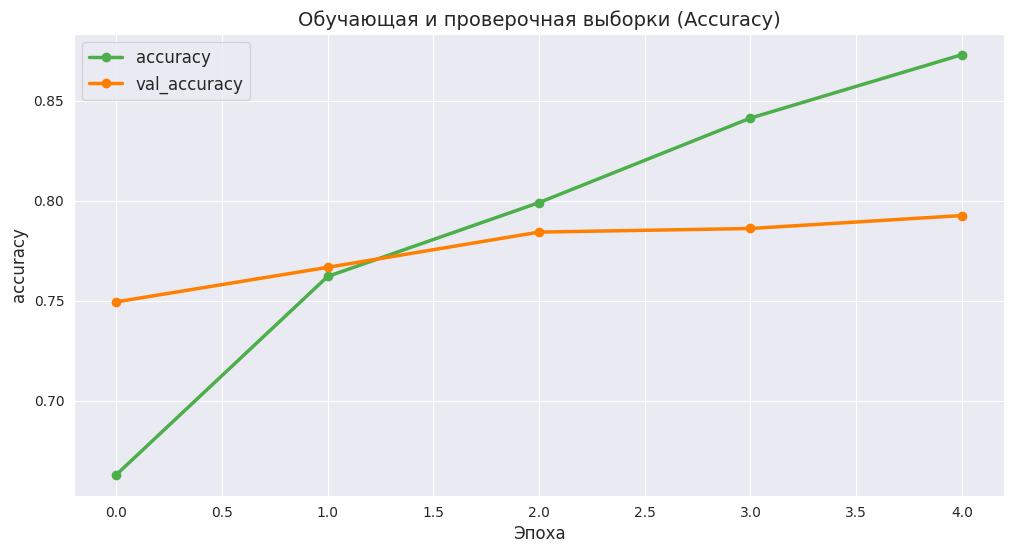

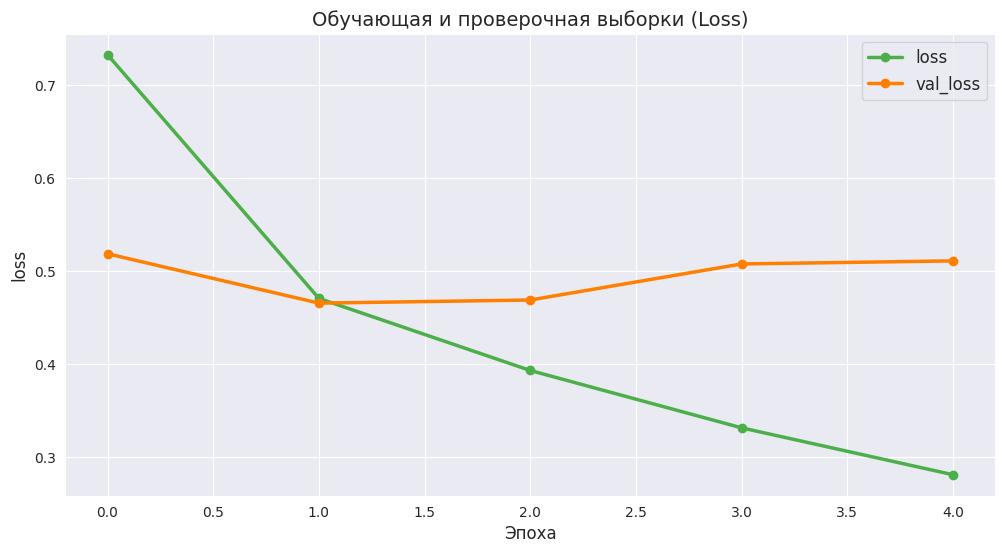

In [107]:
# строим график точности
plot_graphs(result_training, "accuracy")

# строим график потерь
plot_graphs(result_training, "loss")

Для объяснение метрик возьму одну метку класса: change

precision(точность) - показывает, что из всех ПРЕДСКАЗАННЫХ моделью меток change, верными оказались только в 90% (0.90).

recall(полнота) - метрика указывает, что из ВСЕГО КОЛИЧЕСТВА МЕТОК CHANGE, она угадала 85% (0.85).

f1-score - среднее значение между precision и recall, чем больше к 1, тем лучше

support - количество меток

In [114]:
y_pred_indices = np.argmax(y_predicted, axis=1)

y_pred_labels = le.inverse_transform(y_pred_indices)
y_test = le.inverse_transform(y_test)

print(classification_report(y_test, y_pred_labels))


              precision    recall  f1-score   support

      change       0.90      0.85      0.88       313
    incident       0.74      0.85      0.79      1097
     problem       0.58      0.40      0.47       545
     request       0.95      0.97      0.96       826

    accuracy                           0.80      2781
   macro avg       0.79      0.77      0.78      2781
weighted avg       0.79      0.80      0.79      2781



По матрице ошибок видно, что модель сильно путает change и incident, так же request и problem, но не так сильно. Учитывая, тот факт, что в наборе данных есть большой дисбаланс меток


        Incident 40%

        Request 29%

        Change 10%

        Problem 20%
точность 80% для AutoModel это не плохой результат.


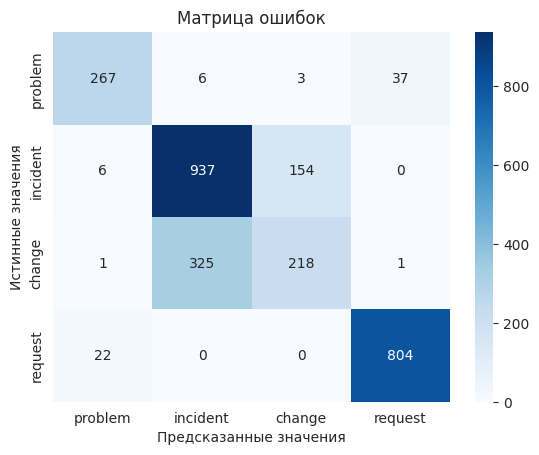

In [115]:
cm = confusion_matrix(y_test, y_pred_labels)

plt.figure()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=set(y_test), yticklabels=set(y_test))
plt.xlabel('Предсказанные значения')
plt.ylabel('Истинные значения')
plt.title('Матрица ошибок')
plt.show()